# Chapter 1
## Randomised SVD
Measurement dimension is increasing rapidly (higher dimensional data); but the whole point of SVD is that, irrespective of this data size, there's still a low number of modes that actually matter (the information we care about is intrinsically low rank). This is what motivated the development of randomised linear algebra methods.

> **_INTUITION_** We can randomly sample the column space of a data matrix $X$ and hope to, just because of randomness, reconstruct the subspace spun by the columns of the actual $U$

We assume that the matrix we are interested in is, indeed, low rank. Then we can undetake the following steps

1. Compute a random projection $P \in \mathbb{R}^{m \times r}$ that we multiply on the column of $X$. Where $r$ is the target rank (this is the *real* rank of the system). Then we will multiply $X$ to the left of $P$: $Z = XP$. This will shrink the number of columns of $X$ from $m$ to $r$. Then we will calculate the QR factorization of $Z$ and $Q$ will then give us an orthonormal basis for $Z$ (and then for $X$ too since $Z$ shares the same column space of $X$). The intuition here is that, is $P$ is random, it will sample a random combination of columns in $X$ through $XP$ and this is why $Z = XP$ can share the same columnspace with $X$, it's just a byproduct of random sampling.
2. Project $X$ onto the low dimensional subspace $Q$. $Y = Q^TX$. Compute the SVD of $Y = U_Y \Sigma_Y V_Y^T$. It can be demonstrated that $\Sigma_Y = \Sigma$ and $V_Y^T=V^T$, in other words $X$ and $Y$ have the same eigenvalues and right singular eigenvectors. Then all I need to do is to calculate $U$ from $U_Y$. $U = QU_Y$ which "lifts" the low dimensional $U_Y$ into the higher dimensional space of $X$

This saves a huge amount of time when $X$ is very large. Randomized SVD comes into 2 flavours:
- Power iterations (very useful if the data matrix is not quite low rank. This is for matrices where the eigenvalues go down slowly or don't go down as fast. Then you take a power of the original matrix which makes bigger eigevalues bigger and smaller eigenvalues smaller.): introduce $X^q = (XX^T)^qX$. You don't compute these matrices, you just multiply $X$ by $XX^T$ q times, from the right. Power iterations come at an extra cost but this is the cost to pay if the distribution of the eigenvalues is suboptimal. Bounds on reconstruction errors can be found.
- Oversampling (just sampling $r+5$ or $r+10$  columsn of $P$ massively improves the process.)

Let's see how this works in an example.

In [190]:
using Plots, LinearAlgebra, Images, Random

function rSVD(Xmat::Matrix{Float64}, r::Int64, q::Int64, p::Int64)
    # step 1
    ny = size(Xmat, 2)
    P = randn(ny, r + p)
    Z = Xmat * P

    for k in 1:q
        tmp = Xmat' * Z
        Z = Xmat * tmp
    end

    Q, R = qr(Z)
    # step 2
    Y = Matrix(Q)' * Xmat

    Uy, S, V = svd(Y, full=false)
    U = Q * Uy
    return U, S, V
end

rSVD (generic function with 2 methods)

We'll use this method on an image of Jupyter and compare the approximation we can get with standard and random SVD

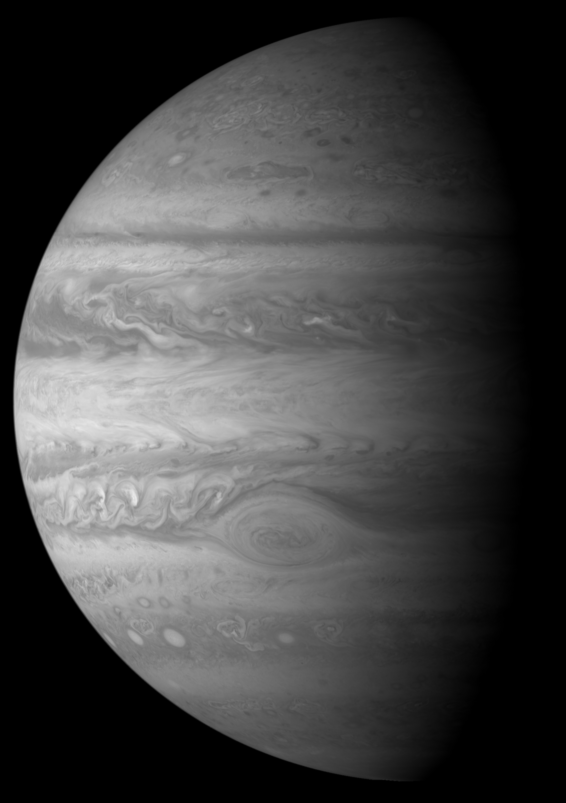

In [168]:
X = Gray.(load("./data/jupiter.jpg"))

Let's compute the "real"/ expensive SVD of this image

In [186]:
U,S,V = svd(X, full=false);

Let's now set the parameters of the rSVD. We are looking for a 400 target rank, 1 power iteration and 5 orders of rank of oversampling.

In [187]:
r = 400
q = 1
p = 5

5

Let's now compute the rSVD.

In [189]:
Xmat = convert(Matrix{Float64}, X);
rU,rS,rV= rSVD(Xmat, r, q, p);

Let's now compare the approximations.

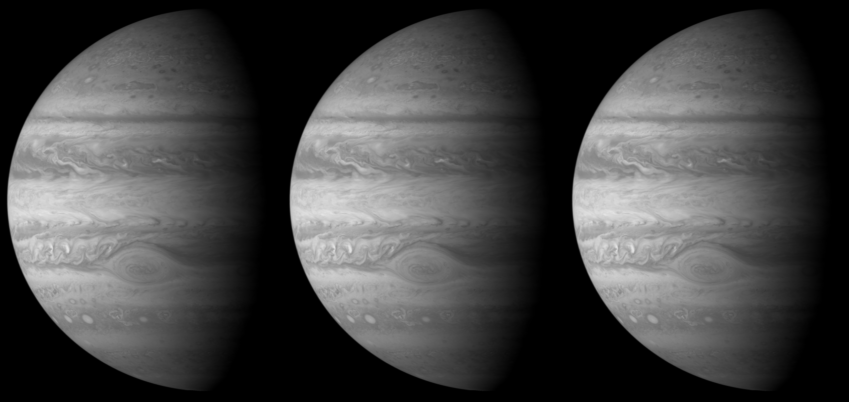

In [191]:
mosaicview(
    Gray.(X),
    Gray.(U[:, 1:r] * Diagonal(S[1:r]) * V[:, 1:r]'),
    Gray.(rU[:, 1:r] * Diagonal(rS[1:r]) * rV[:, 1:r]'), nrow=1
)

We can see all the details by rSVD should be significantly faster than the full SVD.

Let's now study how "power iterations" help in improving the quality of the spectrum of orthogonal bases. Let's do so by studying how this helps in the case of a random matrix (super slow decay of eigenvalues).

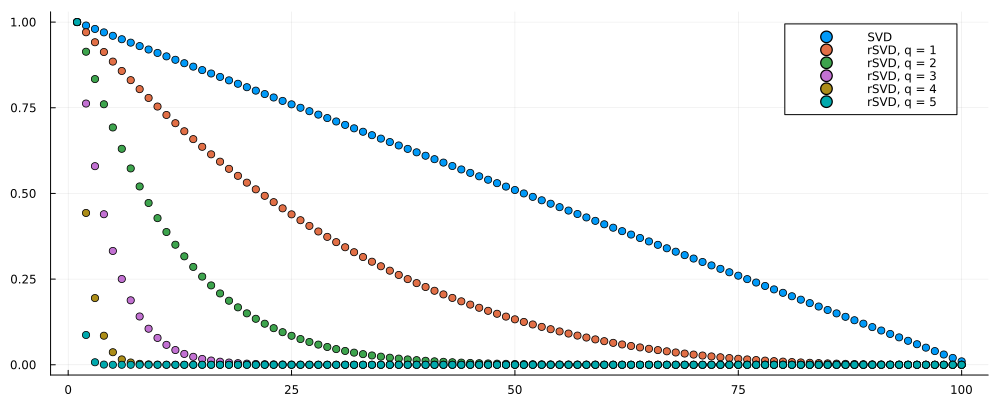

In [220]:
X = randn(1000, 100)

U, S, V = svd(X, full=false)

S = collect(1:-0.01:0.01)
X = U * Diagonal(S) * V'

p = scatter(S, size=(1000, 400), label="SVD")

for i in 1:5 
    X = X * X' * X
    Uq, Sq, Vq = svd(X, full=false)
    p = scatter!(p, Sq, label="rSVD, q = "* string(i))
end
display(p)

As we expected, the more power iterations we perform, the more we differentiate between "noise" eigenvalues (on the floor) and "actually important" (although there is no "signal" eigenvalue in this case.)